In [ ]:
# !pip install opencv-python


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
import os 
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import precision_score, recall_score, classification_report, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load and preprocess the data from the directory
def load_and_preprocess_data(data_path):
    images = []
    labels = []
    for label in data_path.iterdir():
        if label.is_dir():
            for img_path in label.glob('*'):
                img = cv2.imread(str(img_path))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (224, 224))
                images.append(img)
                labels.append(label.name)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [ ]:
# Load data

train_path = pathlib.Path(r"C:\Users\gagan\OneDrive\Desktop\Projects\AIT736_Group_8_FinalProject\archive\Training")
test_path = pathlib.Path(r"C:\Users\gagan\OneDrive\Desktop\Projects\AIT736_Group_8_FinalProject\archive\Testing")

In [5]:
# Load training and testing images and labels
train_images, train_labels = load_and_preprocess_data(train_path)
test_images, test_labels = load_and_preprocess_data(test_path)

In [6]:
# Split the training data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)


In [7]:
# Convert string labels to numerical labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [8]:
# Preprocess the data using DenseNet's preprocess_input function
train_images_densenet = densenet_preprocess_input(train_images)
val_images_densenet = densenet_preprocess_input(val_images)
test_images_densenet = densenet_preprocess_input(test_images)

In [ ]:
# Define model creation function
def create_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [17]:
# Train and evaluate model
model = create_model()
history = model.fit(
    train_images_densenet, train_labels_encoded,
    epochs=10,
    batch_size=32,
    validation_data=(val_images_densenet, val_labels_encoded)
)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 115s 745ms/step - accuracy: 0.6533 - loss: 0.9108 - val_accuracy: 0.8784 - val_loss: 0.3522
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 105s 738ms/step - accuracy: 0.8565 - loss: 0.3878 - val_accuracy: 0.9011 - val_loss: 0.2837
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 95s 668ms/step - accuracy: 0.8686 - loss: 0.3411 - val_accuracy: 0.8863 - val_loss: 0.2933
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 659ms/step - accuracy: 0.8938 - loss: 0.2861 - val_accuracy: 0.9081 - val_loss: 0.2352
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 92s 647ms/step - accuracy: 0.9152 - loss: 0.2368 - val_accuracy: 0.9055 - val_loss: 0.2624
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 637ms/step - accuracy: 0.9147 - loss: 0.2197 - val_accuracy: 0.9239 - val_loss: 0.2049
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 92s 644ms/step - accuracy: 0.9140 - loss: 0.2311 - val_accuracy: 0.9248 - val_loss: 0.2026
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 630ms/step - accuracy: 0.9284 - loss:

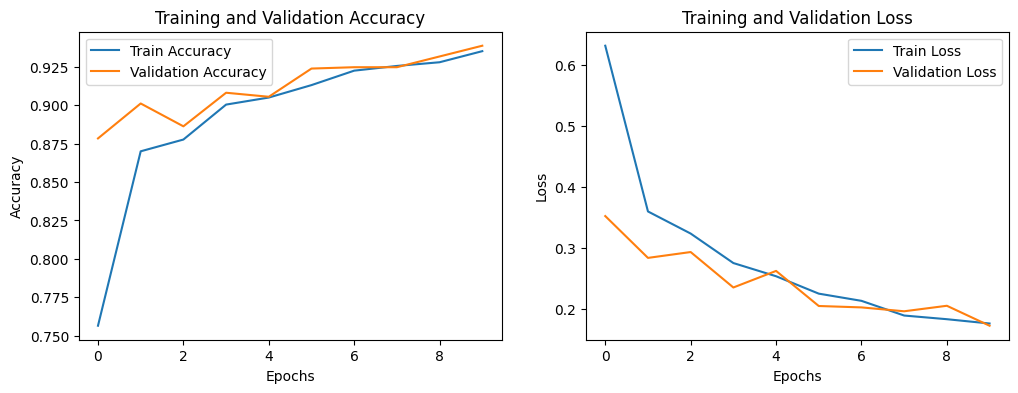

In [18]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Fine-tuning the model by unfreezing some layers
fine_tune_at = len(model.layers[0].layers) - 40

for layer in model.layers[0].layers[:fine_tune_at]:
    layer.trainable = False
for layer in model.layers[0].layers[fine_tune_at:]:
    layer.trainable = True

In [20]:
# Compile again with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Adding early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [21]:
# Fine-tuning training
history_fine = model.fit(
    train_images_densenet, train_labels_encoded,
    epochs=10,
    batch_size=32,
    validation_data=(val_images_densenet, val_labels_encoded),
    callbacks=[early_stopping]
)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 111s 705ms/step - accuracy: 0.7910 - loss: 0.6153 - val_accuracy: 0.9265 - val_loss: 0.1930
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 96s 669ms/step - accuracy: 0.9001 - loss: 0.2951 - val_accuracy: 0.9265 - val_loss: 0.1945
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 95s 664ms/step - accuracy: 0.9295 - loss: 0.2007 - val_accuracy: 0.9326 - val_loss: 0.1885
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 96s 673ms/step - accuracy: 0.9214 - loss: 0.1969 - val_accuracy: 0.9379 - val_loss: 0.1763
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 95s 665ms/step - accuracy: 0.9491 - loss: 0.1434 - val_accuracy: 0.9396 - val_loss: 0.1716
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 650ms/step - accuracy: 0.9500 - loss: 0.1408 - val_accuracy: 0.9414 - val_loss: 0.1658
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 653ms/step - accuracy: 0.9586 - loss: 0.1164 - val_accuracy: 0.9440 - val_loss: 0.1610
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 657ms/step - accuracy: 0.9572 - loss: 

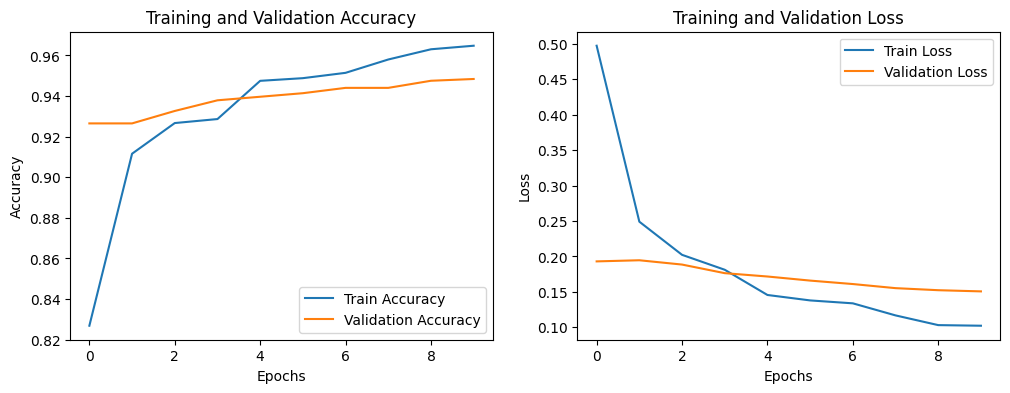

In [24]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Train Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [25]:
# Run predictions on the test set
predictions = model.predict(test_images_densenet)
predicted_classes = np.argmax(predictions, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 502ms/step


In [ ]:
# Calculate accuracy and loss for test images
test_loss, test_accuracy = model.evaluate(test_images_densenet, test_labels_encoded, verbose=1)
print(f'Fine-tuned Test Loss: {test_loss}')
print(f'Fine-tuned Test Accuracy: {test_accuracy}\n')

41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 566ms/step - accuracy: 0.9316 - loss: 0.2126
Fine-tuned Test Loss: 0.1512228548526764
Fine-tuned Test Accuracy: 0.950419545173645



In [ ]:
# Print classification report with precision, recall, and F1-score for each class
print("Classification Report:")
print(classification_report(test_labels_encoded, predicted_classes, target_names=label_encoder.classes_))



Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.90      0.93       300
  meningioma       0.88      0.91      0.90       306
     notumor       0.98      0.99      0.99       405
   pituitary       0.97      0.98      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



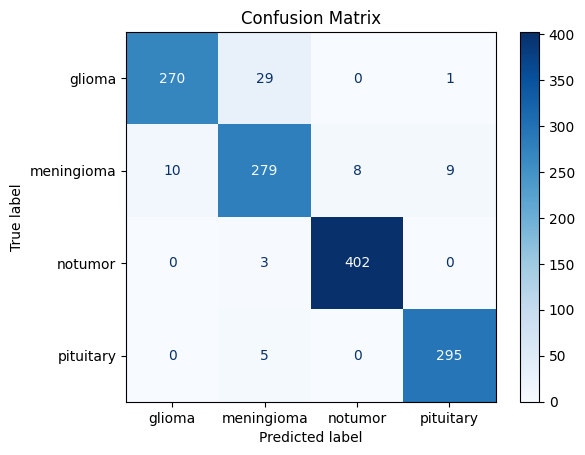

In [29]:
# Confusion Matrix
cm = confusion_matrix(test_labels_encoded, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# ROC AUC
# Binarize the true labels for multi-class ROC AUC
y_test_binarized = label_binarize(test_labels_encoded, classes=np.unique(test_labels_encoded))

# Calculate overall ROC AUC score for multi-class classification
roc_auc = roc_auc_score(y_test_binarized, predictions, multi_class='ovr')
print(f'Overall ROC AUC Score: {roc_auc}')

Overall ROC AUC Score: 0.9941225218259697


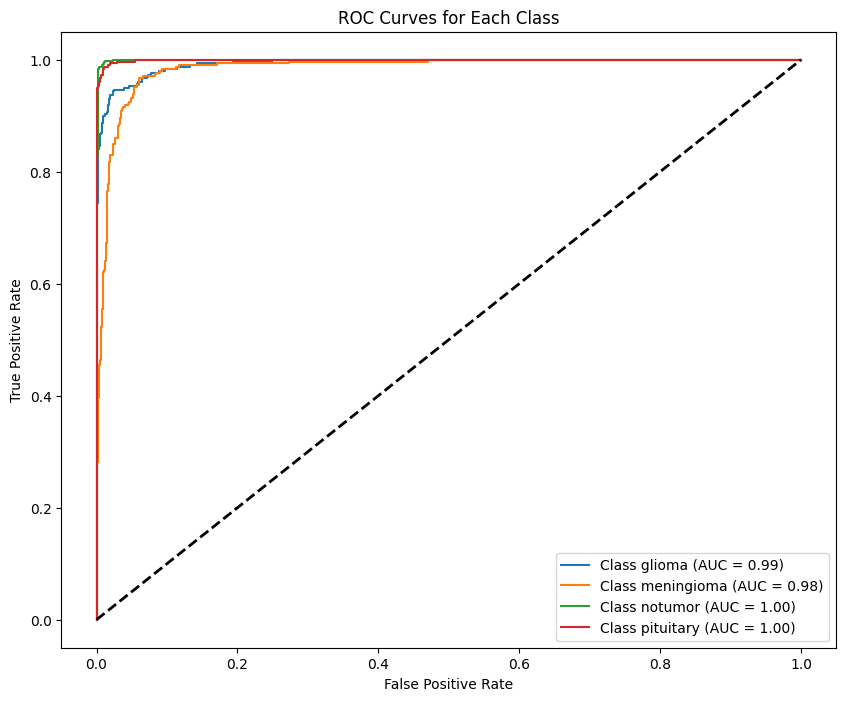

In [31]:
# Plot ROC curves for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], predictions[:, i])

# Plotting the ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:0.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Save the fine-tuned model as a .h5 file

# model.save("Densenet_Final.h5")

In [33]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,483,214 (36.18 MB)

 Trainable params: 1,091,140 (4.16 MB)

 Non-trainable params: 6,209,792 (23.69 MB)

 Optimizer params: 2,182,282 (8.32 MB)